# Compact Convolutional Transformers
### 紧凑卷积Transformers

原文链接：https://keras.io/examples/vision/cct/

## Note：
这个案例是用紧凑卷积 Transformers 实现图像分类。总体来说这个案例比较简单，代码量也很少，对 Transformer 了解的话读起来会相当轻松。如果对这个模型不熟悉也没关系，先跟着做下去，因为 Keras Example 的顺序比较乱，后面有一个案例详解了 Transformer 包括具体实现。  

目前你需要知道的是，Transformer 最初被用在自然语言处理上，其主要是多头注意力机制构成的编码器和解码器，然后有学者将 Transformer 应用到了图像识别领域中发现效果也非常好。在 Computer Vision 部分先讨论 Vision Transformer（ViT）相关的内容，后面的自然语言处理中会介绍原始用于翻译的 Transormer。  

虽然该模型有望成为 CV 和 NLP 中的大一统方案，但该模型在 CV 方面有两个缺陷：  
1. 当数据集非常大（百万以上）的时候才会表现出和 ResNet 之间的性能差异。
2. 模型时间和空间复杂度均为 $O(n^{2})$。

其实第二个缺陷已经非常致命了，所以后面就有大量的魔改版。这个案例的来源就是一篇魔改论文。作者提出了一种结构更为紧凑的 Transformer 模型（**【注意】不是 ViT 模型**），该模型所需的数据集较小，同时也更容易训练。

--------

As discussed in the [Vision Transformers (ViT)](https://arxiv.org/abs/2010.11929) paper, a Transformer-based architecture for vision typically requires a larger dataset than usual, as well as a longer pre-training schedule. [ImageNet-1k](http://imagenet.org/)  (which has about a million images) is considered to fall under the medium-sized data regime with respect to ViTs. This is primarily because, unlike CNNs, ViTs (or a typical Transformer-based architecture) do not have well-informed inductive biases (such as convolutions for processing images). This begs the question: can't we combine the benefits of convolution and the benefits of Transformers in a single network architecture? These benefits include parameter-efficiency, and self-attention to process long-range and global dependencies (interactions between different regions in an image).  

正如 [Vision Transformers (ViT)](https://arxiv.org/abs/2010.11929) 这篇文章所说的，基于 Transformer 的视觉架构通常需要更大的数据集，以及更长的训练时间。[ImageNet-1k](http://imagenet.org/) （约一百万张）被认为是 ViT 框架下的中型数据集。造成这一现象的原因是 ViT 没有被广泛认同的 **归纳偏置** 能力（如 CNN 的卷积）。这样就引出了一个问题：能否将卷积和 Transformer 的优点结合到一个框架下？这些优点包括了参数训练效率、用于处理大跨度和全局依赖（图像中不同区域之间的联系）的自注意力。

上面的描述中出现了一个关键词 **归纳偏置**。   

归纳偏置这个词翻译的有些生硬，我比较认同 知乎博主 **Yulong** 在博客 [深度学习的归纳偏置是什么？](https://www.zhihu.com/question/41404496/answer/1612466556) 所说的 **“归纳偏好”**。当面对一个需要使用神经网络解决的问题时，第一个想到的方案就是 **归纳偏好**。再次引用 **Yulong** 在 [博客](https://www.zhihu.com/question/41404496/answer/1612466556) 中的话：
```python
1. 深度神经网络（多层感知机）结构就偏好性的认为，层次化处理信息有更好效果；
2. 卷积神经网络认为信息具有空间局部性（locality），可以用滑动卷积共享权重方式降低参数空间；
3. 反馈神经网络则将时序信息考虑进来强调顺序重要性；
4. 图网络则是认为中心节点与邻居节点的相似性会更好引导信息流动。
```

对于神经网络而言，CNN 的归纳偏好就是卷积操作带来的平移不变性；RNN的归纳偏好是序列的前后时序性。  

因此上面这段话的意思是，ViT 没有被广泛地认同用于图像任务中，即 ViT 在小规模数据上表现并不理想，相比较于深度卷积和 ResNet 这类通吃大中小数据集的模型而言，图像处理过程中 ViT 并不是最佳选择。

In [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/abs/2104.05704), Hassani et al. present an approach for doing exactly this. They proposed the Compact Convolutional Transformer (CCT) architecture. In this example, we will work on an implementation of CCT and we will see how well it performs on the CIFAR-10 dataset.  

在文章 [Escaping the Big Data Paradigm with Compact Transformers](https://arxiv.org/abs/2104.05704) 中，作者提出了一种紧凑型 Transformer 结构（CCT）来解决其需要大规模数据的问题。这个案例演示了该模型在 CIFAR-10 上的表现。  

If you are unfamiliar with the concept of self-attention or Transformers, you can read this chapter from François Chollet's book Deep Learning with Python. This example uses code snippets from another example, [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/).  

如果你不熟悉 self-attention 或 Transformers，你可以阅读 François Chollet 的书 《Deep Learning with Python》 [这一章节](https://livebook.manning.com/book/deep-learning-with-python-second-edition/chapter-11/r-3/312)，顺便参考 [Image classification with Vision Transformer](https://keras.io/examples/vision/image_classification_with_vision_transformer/) 这个示例。

下图展示了他们在论文中提出的模型（CCT）结构。

<img src='../images/CV_Img/CCT.png'>  

从图中可以发现 ViT 和 CVT 都使用基于 Patch 的标记作为输入，而 CCT 使用的是卷积结果作为标记。如下图所示，将一张图片卷积的结果作为 Patch 以替代通过切割得到的 Patch。  

这样做有一个显而易见的好处：卷积操作是使用一个卷积核扫遍整个图得到的一个特征图（Feature Map），那么这个特征图就包含了这张照片的全局信息；而如果是 CVT 和 ViT 切割的话，切割区域不重叠会使得每个 Patch 之间的边缘关系被弱化，同时大跨度的两个 Patch（左上角和右下角） 之间关系则更弱。  

<img src='../images/CV_Img/CCT_CVT.png'>

---------

## Imports

In [1]:
from tensorflow.keras import layers
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np

---------

## Hyperparameters and constants

In [2]:
positional_emb = True
conv_layers = 2
projection_dim = 128

In [3]:
num_heads = 2
transformer_units = [
    projection_dim,
    projection_dim,
]
transformer_layers = 2
stochastic_depth_rate = 0.1

In [4]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 10
image_size = 32

------

## Load CIFAR-10 dataset

In [5]:
num_classes = 10
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


------

## The CCT tokenizer
The first recipe introduced by the CCT authors is the tokenizer for processing the images. In a standard ViT, images are organized into uniform non-overlapping patches. This eliminates the boundary-level information present in between different patches. This is important for a neural network to effectively exploit the locality information. The figure below presents an illustration of how images are organized into patches.  

CCT 作者介绍的第一个优化是在图像标记器 （Tokenizer）上。在标准 ViT 中，图像被组织成统一的非重叠 Patch。这样做抹除了不同 Patch 之间的边界信息。不同区域之间的边界信息对于神经网络利用局部信息而言很重要。下图展示了传统 Vit 的做法。  

<img src='../images/CV_Img/CCT_example.png'>

为了解决边界信息丢失的问题，作者使用卷积的方式来生成右边的 Patchs 图。

In [6]:
class CCTTokenizer(layers.Layer):
    def __init__(
        self,
        kernel_size=3,
        stride=1,
        padding=1,
        pooling_kernel_size=3,
        pooling_stride=2,
        num_conv_layers=conv_layers,
        num_output_channels=[64, 128],
        positional_emb=positional_emb,
        **kwargs,
    ):
        super(CCTTokenizer, self).__init__(**kwargs)

        # This is our tokenizer. 这是标记器
        self.conv_model = keras.Sequential()
        for i in range(num_conv_layers):
            self.conv_model.add(
                layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                )
            )
            self.conv_model.add(layers.ZeroPadding2D(padding))
            self.conv_model.add(
                layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same")
            )

        self.positional_emb = positional_emb

    def call(self, images):
        outputs = self.conv_model(images)
        # 图像通过上面的卷积层后，将其压平（Flatten）成一个向量
        reshaped = tf.reshape(
            outputs,
            (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]),
        )
        return reshaped

    def positional_embedding(self, image_size):
        # 位置编码在CCT中是可选的，如果要做位置编码就返回一个 Embedding 功能层
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

--------

## Stochastic depth for regularization
Stochastic depth is a regularization technique that randomly drops a set of layers. During inference, the layers are kept as they are. It is very much similar to Dropout but only that it operates on a block of layers rather than individual nodes present inside a layer. In CCT, stochastic depth is used just before the residual blocks of a Transformers encoder.  

随机深度（Stochastic depth）是一种随机删除一层的正则化技术。在预测过程中并不会删除。这个和 Dropout 非常相似，但 Dropout 是对层内的神经元进行随机休克，而 stochastic depth 是以层为单位进行随机休眠。在 CCT 中，随机深度作用于 Transformer 编码器之前的残差卷积模块中。

In [7]:
# Referred from: github.com:rwightman/pytorch-image-models.
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop

    def call(self, x, training=None):
        if training: # 如果是训练则随机深度，预测则保持原样
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (len(tf.shape(x)) - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

--------

## MLP for the Transformers encoder

In [8]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

--------

## Data augmentation
In the original paper, the authors use [AutoAugment](https://arxiv.org/abs/1805.09501) to induce stronger regularization. For this example, we will be using the standard geometric augmentations like random cropping and flipping.  

在 [原始论文](https://arxiv.org/abs/2104.05704) 中，作者使用了 [AutoAugment](https://arxiv.org/abs/1805.09501) 进行数据增强。但在这个例子中使用标准的几何增强，如剪裁和翻转。

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Rescaling(scale=1.0 / 255),
        layers.RandomCrop(image_size, image_size),
        layers.RandomFlip("horizontal"),
    ],
    name="data_augmentation",
)

--------

## The final CCT model
Another recipe introduced in CCT is attention pooling or sequence pooling. In ViT, only the feature map corresponding to the class token is pooled and is then used for the subsequent classification task (or any other downstream task). In CCT, outputs from the Transformers encoder are weighted and then passed on to the final task-specific layer (in this example, we do classification).  

CCT 另一个改进是 **注意力池** 或 **序列池**。在 ViT 中，只有与标记对应的特征图被池化，然后用于后续的分类任务。在 CCT 中，Transformer 编码器的加权输出被送入下游任务层中。（在这个例子中是分类）。

在这里有个新名词“注意力池”，其主要功能是将 Transformer Encoder 产生的序列信息进行池化。在下面的代码中是通过 **tf.squeeze()** 函数实现的。该函数能够删除输入的指定维度，此处直接删除了倒数第二个维度。

In [10]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data. 数据增强
    augmented = data_augmentation(inputs)

    # Encode patches. 编码Patch
    cct_tokenizer = CCTTokenizer()
    encoded_patches = cct_tokenizer(augmented)

    # Apply positional embedding. 位置嵌入
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities. 计算随深度概率
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block. 构建多层Transformer
    for i in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-5)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        x3 = StochasticDepth(dpr[i])(x3)
        encoded_patches = layers.Add()([x3, x2])

    # Apply sequence pooling. 序列池化，删除倒数第二个维度
    representation = layers.LayerNormalization(epsilon=1e-5)(encoded_patches)
    attention_weights = tf.nn.softmax(layers.Dense(1)(representation), axis=1)
    weighted_representation = tf.matmul(
        attention_weights, representation, transpose_a=True
    )
    weighted_representation = tf.squeeze(weighted_representation, -2)

    # Classify outputs. 分类输出层
    logits = layers.Dense(num_classes)(weighted_representation)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

------

## Model training and evaluation

In [11]:
import os

folderPath = "tmp/"
if not os.path.exists(folderPath):
    os.makedirs(folderPath)

In [12]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=0.0001)

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(
            from_logits=True, label_smoothing=0.1
        ),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = folderPath
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [13]:
cct_model = create_cct_model()
history = run_experiment(cct_model)

Epoch 1/10
352/352 [==============================] - 17s 40ms/step - loss: 1.9022 - accuracy: 0.3372 - top-5-accuracy: 0.8285 - val_loss: 1.6442 - val_accuracy: 0.4418 - val_top-5-accuracy: 0.9198
Epoch 2/10
352/352 [==============================] - 14s 39ms/step - loss: 1.5686 - accuracy: 0.5004 - top-5-accuracy: 0.9315 - val_loss: 1.4918 - val_accuracy: 0.5482 - val_top-5-accuracy: 0.9456
Epoch 3/10
352/352 [==============================] - 14s 39ms/step - loss: 1.4471 - accuracy: 0.5620 - top-5-accuracy: 0.9486 - val_loss: 1.4273 - val_accuracy: 0.5644 - val_top-5-accuracy: 0.9530
Epoch 4/10
352/352 [==============================] - 14s 39ms/step - loss: 1.3646 - accuracy: 0.6047 - top-5-accuracy: 0.9579 - val_loss: 1.3147 - val_accuracy: 0.6238 - val_top-5-accuracy: 0.9658
Epoch 5/10
352/352 [==============================] - 14s 39ms/step - loss: 1.3053 - accuracy: 0.6345 - top-5-accuracy: 0.9645 - val_loss: 1.2620 - val_accuracy: 0.6448 - val_top-5-accuracy: 0.9696
Epoch 6/10

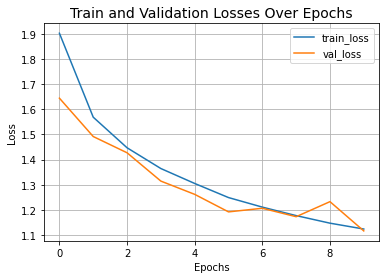

In [14]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

上面的 CCT 模型仅有40万个参数，能够快速地完成在 CIFAR-10 上的训练，可以发现仅仅 10 个epoch 就能将准确率提到 % 以上。相比较于 ViT 的470万个参数而言是相当少的。从训练的记录来看，模型的准确率也能迅速提高，训练时间也非常短。